In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path
from usagestats.bookingdb import BookingDB
from datetime import datetime, timedelta
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from usagestats import visual

db_file = "bookings.db"
folder = Path(
    "/run/user/1000/gvfs/smb-share:server=istore,share=microscopy_group_share,user=jeromeb/Admin/Usage Stats/2024"
)

local_tz = pytz.timezone("Europe/London")
num_weeks = 52
start_date = datetime.fromisoformat("2023-11-02").replace(tzinfo=local_tz)
end_date = start_date + timedelta(weeks=num_weeks)  # iso-format data yyyy-mm-dd
drop_bookings_type = ["service", "maintenance", "training"]
drop_instrument = [
    "Analysis PC1",
    "Analysis PC2",
    "Analysis PC3",
    "Analysis PC4"]

with BookingDB(db_file) as db:
    bookings = db.get_events_in_range(start_date, end_date)

# fix booking types
def get_type_from_str(x):
    types = {'serv':'service','maint':'maintenance','train':'training','maintenace':'maintenance'}
    for y in types:
        if x.lower().find(y)>=0:
            return types[y]
    return 'default'

bookings['type'] = [get_type_from_str(x) for x in bookings['subject']]

## Booking by type

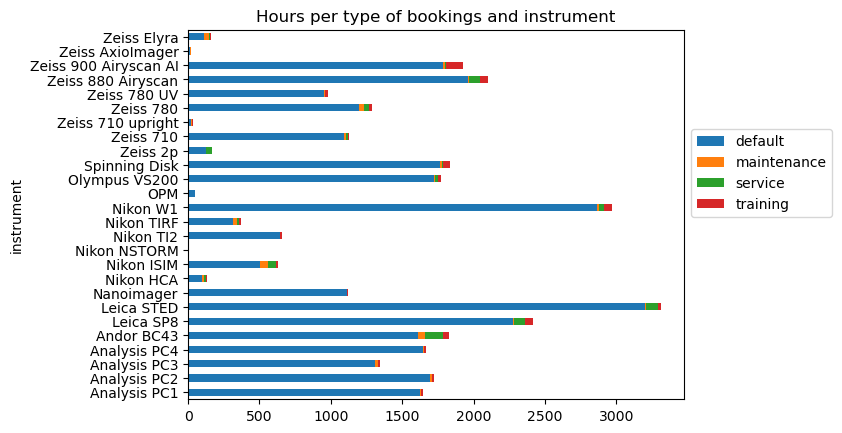

In [3]:
ti = (
    bookings.groupby(["type", "instrument"], as_index=False)
    .agg(
        hours=pd.NamedAgg(column="hours", aggfunc="sum")
    )
    .pivot(index="instrument", values="hours", columns="type")
)
# ti.to_csv(folder / "booking-by-type-and-instrument.csv")

ti.plot(kind="barh", stacked=True)
plt.legend(bbox_to_anchor=(1, 0.75))
plt.title("Hours per type of bookings and instrument")
plt.savefig(
    folder / "usage-per-type-per-instrument.pdf", pad_inches=1.2, bbox_inches="tight"
)

## Drop maintenance and analysis pc

In [4]:
# excludes special bookings
bookings = bookings[~bookings["type"].isin(drop_bookings_type)]
# excludes instruments
bookings = bookings[~bookings["instrument"].isin(drop_instrument)]
# exclude unknown
bookings = bookings[bookings["group"]!="Unknown"]
bookings = bookings[bookings["division"]!="Unknown"]
bookings.head()

,hours,start,end,user,group,division,instrument,type,subject
1970,15.0,2024-10-02 18:01:00+00:00,2024-10-03 09:01:00+00:00,Anna Jansson,Schafer,Neurobiology,Andor BC43,default,anna
1971,1.0,2024-10-21 13:31:00+00:00,2024-10-21 14:31:00+00:00,Sarah Lecinski,Light Microscopy,Cell Biology,Andor BC43,default,sarah andor
1972,3.0,2024-09-23 15:01:00+00:00,2024-09-23 18:01:00+00:00,Oliver Knowles,Allegretti,Structural Studies,Andor BC43,default,oliver
1973,3.0,2024-06-17 14:01:00+00:00,2024-06-17 17:01:00+00:00,Oliver Knowles,Allegretti,Structural Studies,Andor BC43,default,oliver
1974,2.0,2024-05-21 14:31:00+00:00,2024-05-21 16:31:00+00:00,Feline Lindhout,Lancaster,Cell Biology,Andor BC43,default,feline lindhout


In [5]:
info_str = visual.get_title_str(bookings, start_date, end_date)

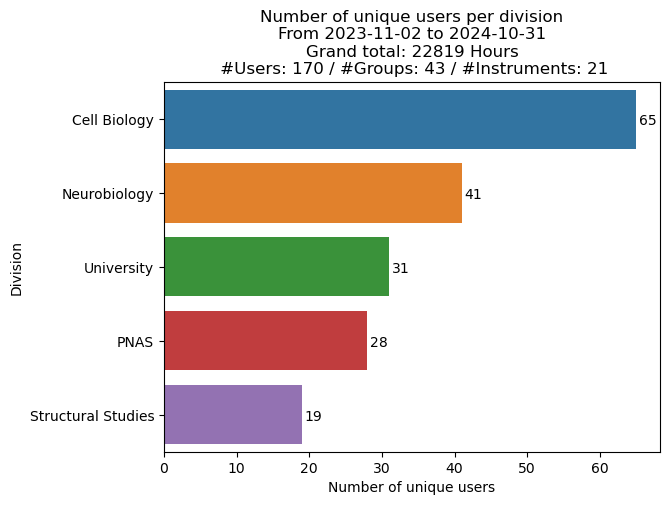

In [6]:
with BookingDB(db_file) as db:
    unique_users = db.get_unique_users_in_range(start_date, end_date)
unique_users = unique_users[unique_users["division"]!="Unknown"]
stats = unique_users.groupby('division')[['name']].count().sort_values('name',ascending=False)
ax = sns.barplot(data=stats,x='name',y='division',hue='division')
visual.show_values_on_bars(ax,'h',hspace=0.4)
plt.xlabel('Number of unique users')
plt.ylabel('Division')
plt.title('Number of unique users per division'+info_str)
plt.savefig(folder/'users-per-division.pdf',pad_inches=1.2,bbox_inches='tight')

## Usage per division

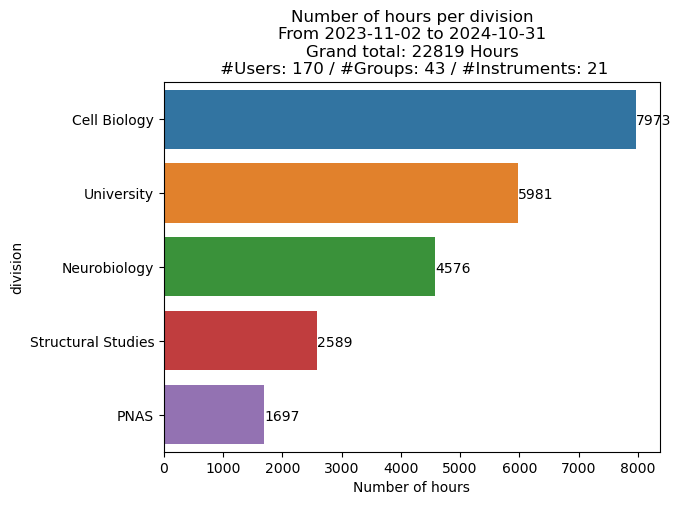

In [7]:

stats = (
    bookings.groupby("division")
    .agg(hours=pd.NamedAgg(column="hours", aggfunc="sum"))
    .sort_values("hours", ascending=False)
)

ax = sns.barplot(data=stats, x="hours", y="division", hue="division")
visual.show_values_on_bars(ax,'h',hspace=0.4)
plt.xlabel('Number of hours')
plt.title('Number of hours per division'+info_str)
plt.savefig(folder/'hours-per-division.pdf',pad_inches=1.2,bbox_inches='tight')

## Usage per group

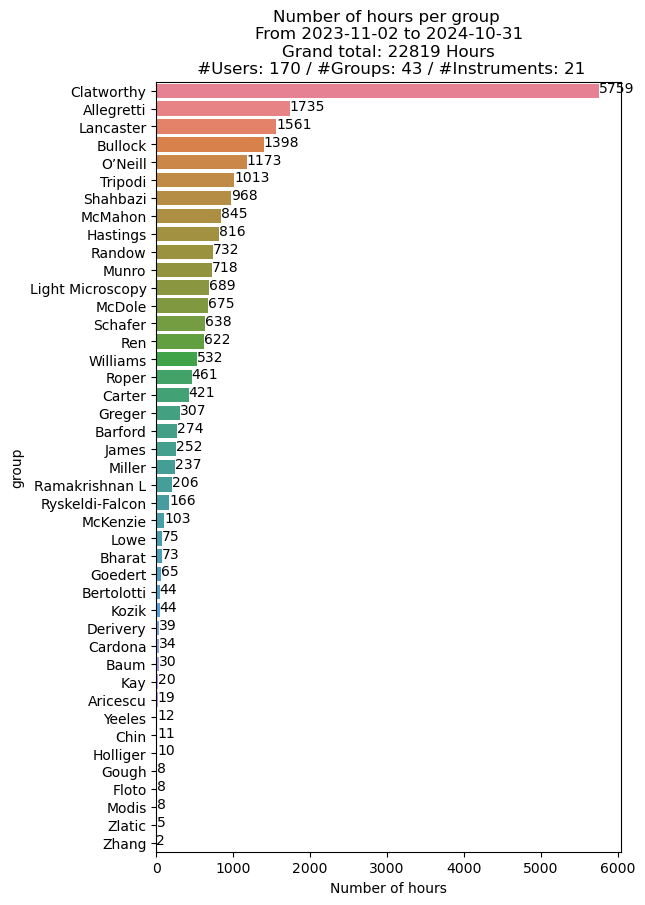

In [8]:
from usagestats import visual

stats = (
    bookings.groupby("group")
    .agg(hours=pd.NamedAgg(column="hours", aggfunc="sum"))
    .sort_values("hours", ascending=False)
)

f, ax = plt.subplots(figsize=(6, 10))
ax = sns.barplot(data=stats, x="hours", y="group", hue="group")
visual.show_values_on_bars(ax,'h',hspace=0.4)
plt.xlabel('Number of hours')
plt.title('Number of hours per group '+info_str)
plt.savefig(folder/'hours-per-group.pdf',pad_inches=1.2,bbox_inches='tight')

## Usage by instrument

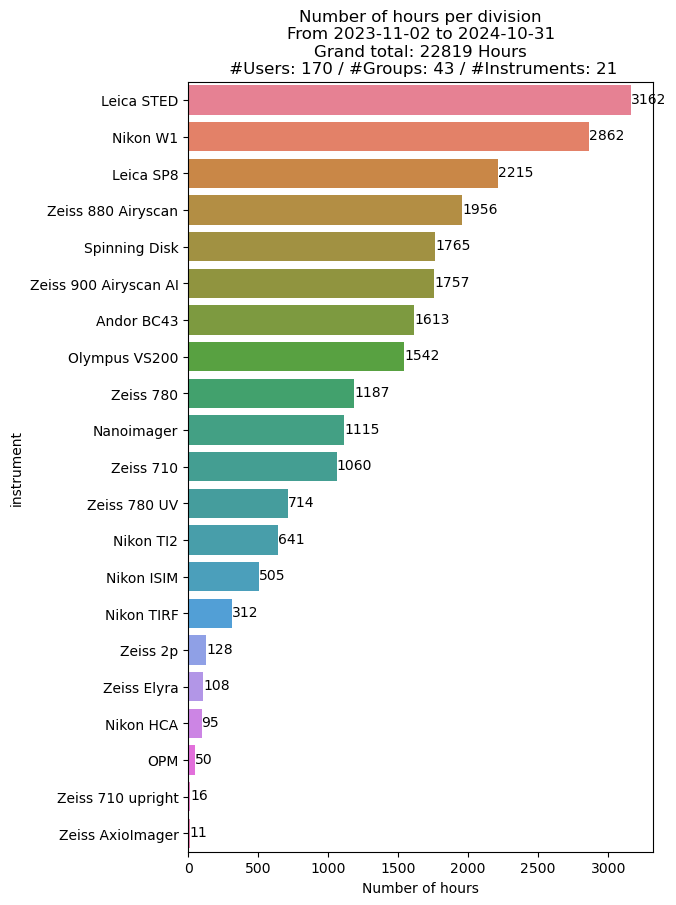

In [9]:
from usagestats import visual
stats = (
    bookings.groupby("instrument")
    .agg(hours=pd.NamedAgg(column="hours", aggfunc="sum"))
    .sort_values("hours", ascending=False)
)
f, ax = plt.subplots(figsize=(6, 10))
ax = sns.barplot(data=stats, x="hours", y="instrument", hue="instrument")
visual.show_values_on_bars(ax,'h',hspace=0.4)
plt.xlabel('Number of hours')
plt.title('Number of hours per division'+info_str)
plt.savefig(folder/'hours-per-instruments.pdf',pad_inches=1.2,bbox_inches='tight')

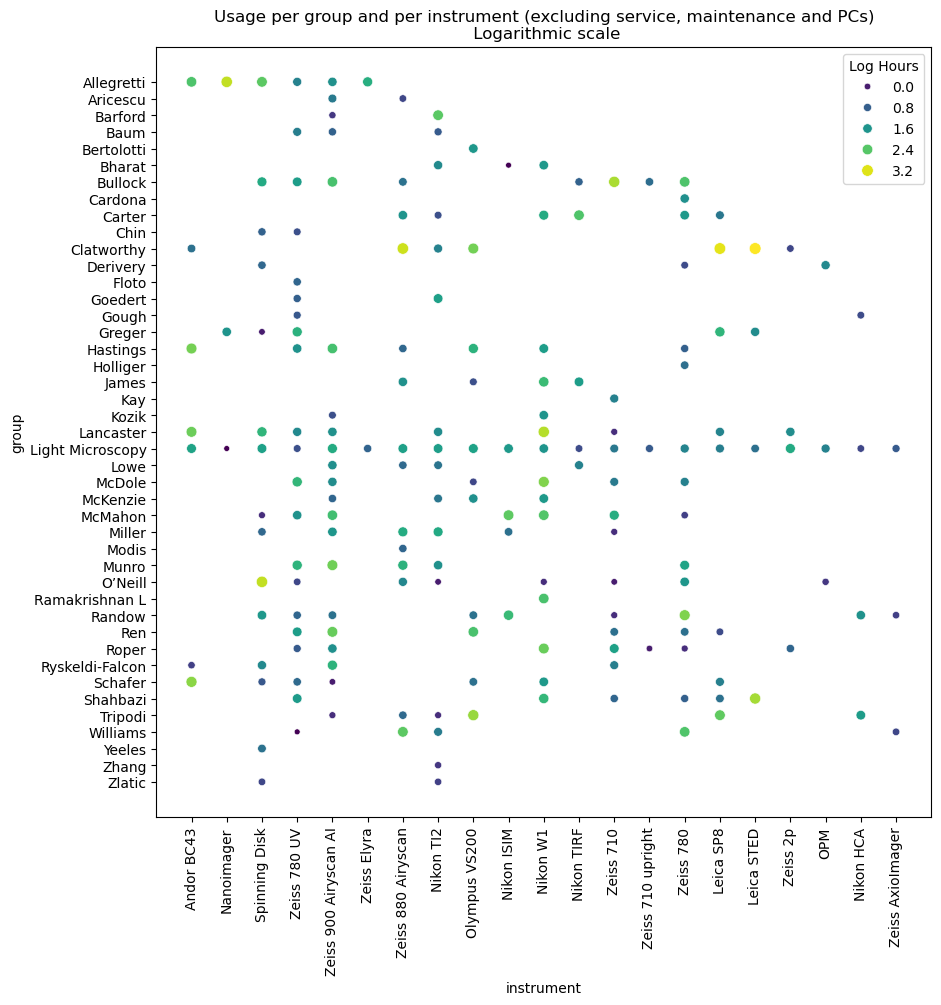

In [10]:
import math
#bookings.groupby(['Group','Instrument'], as_index=False)['Hours'].agg('sum').pivot(index="Group",columns="Instrument",values='Hours').fillna(0).to_csv('usage-per-group-per-instrument.csv')
f,x = plt.subplots(figsize=(10,10))
tmp = bookings.groupby(['group','instrument'], as_index=False)['hours'].agg('sum')
tmp['hours'] = [math.log10(x) for x in tmp['hours']]
cmap = sns.color_palette("viridis", as_cmap=True)
#order = tmp.groupby('Group').agg(time=('Hours',sum)).sort_values('time',ascending=False).index.values
sns.scatterplot(data=tmp, x='instrument', y='group', size='hours', hue='hours',palette=cmap)
plt.xticks(rotation=90)
plt.title('Usage per group and per instrument (excluding service, maintenance and PCs)\n Logarithmic scale')
plt.legend(title="Log Hours")
plt.savefig(folder/'usage-per-group-per-instrument.pdf',pad_inches=1.2,bbox_inches='tight')

## By user

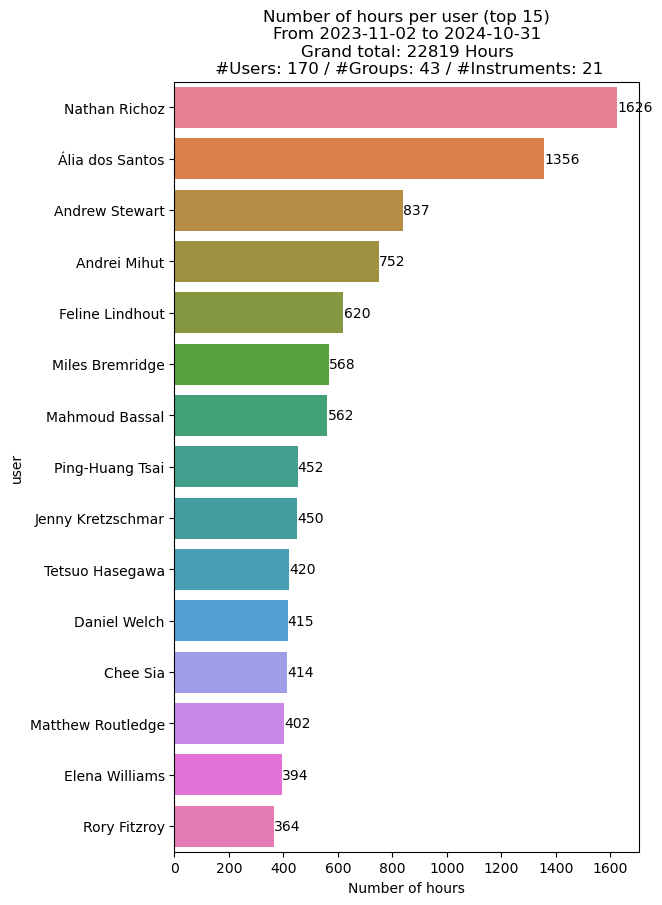

In [11]:
from usagestats import visual
stats = (
    bookings.groupby("user")
    .agg(hours=pd.NamedAgg(column="hours", aggfunc="sum"))
    .sort_values("hours", ascending=False)
)

f, ax = plt.subplots(figsize=(6, 10))
ax = sns.barplot(data=stats.iloc[:15], x="hours", y="user", hue="user")
visual.show_values_on_bars(ax,'h',hspace=0.4)
plt.xlabel('Number of hours')
plt.title('Number of hours per user (top 15)'+info_str)
plt.savefig(folder/'hours-per-userspdf',pad_inches=1.2,bbox_inches='tight')

## Weekly usage

In [12]:
usage = visual.weekly_usage_by_instrument(bookings, start_date, end_date)

/tmp/ipykernel_392660/3088123979.py:10: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  avg_global = averages.mean()[0]


<Figure size 3000x2000 with 0 Axes>

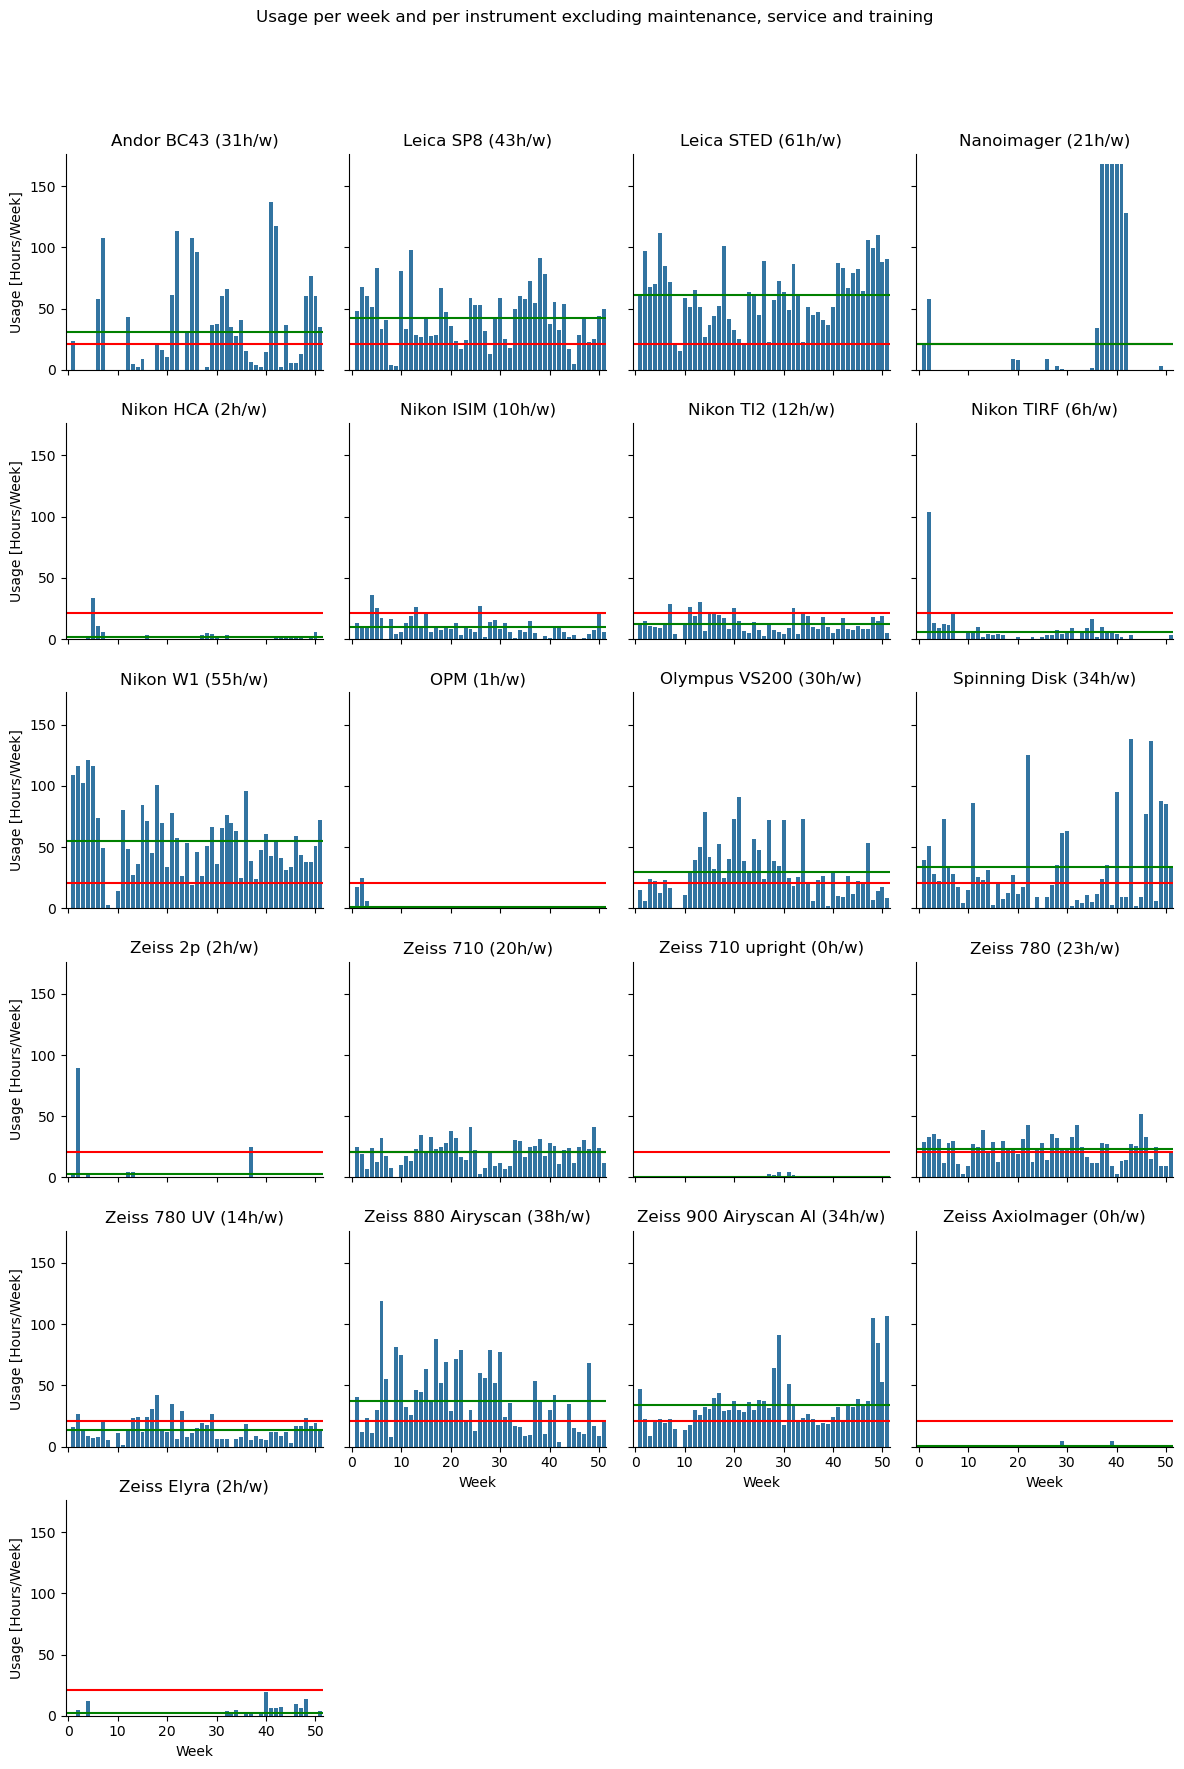

In [13]:
import numpy as np

# figure for each instruments
plt.figure(figsize=(30, 20))
col_order = [*usage["Instrument"].unique()]
col_order.sort()
g = sns.FacetGrid(usage, col="Instrument", col_wrap=4, col_order=col_order)
p = g.map(sns.barplot, "Week", "Usage", order=np.arange(num_weeks))
averages = usage.groupby("Instrument")["Usage"].agg(["mean"])
avg_global = averages.mean()[0]

for k, a in enumerate(p.axes):
    mic = a.get_title().replace("Instrument = ", "")
    avg = averages["mean"][mic]
    a.set_title(f"{mic} ({avg:.0f}h/w)")
    # a.text(15,130,f'average:{avg:.0f}h/w')
    # a.set_subtitle(f'average:{avg:.0f}h/w')
    a.axhline(avg_global, color="r", linestyle="-")
    a.axhline(avg, color="g", linestyle="-")
    a.set_ylabel("Usage [Hours/Week]")
    a.set_xticks(np.arange(0, num_weeks, step=10))
    a.set_xticklabels(np.arange(0, num_weeks, step=10))
plt.subplots_adjust(top=0.9)
plt.suptitle("Usage per week and per instrument excluding maintenance, service and training")
plt.savefig(folder/'usage-per-instrument-per-week.pdf')